Train size: 20943
Test size: 5236

Random images selected:
 -> D:\EDGE_INTELLIGENCE_LAB\archive (16)\raw-img\ragno\OIP-raixJwwtKkVRXErTW5hvRwHaHa.jpeg
 -> D:\EDGE_INTELLIGENCE_LAB\archive (16)\raw-img\cavallo\OIP-LNLYTodvKr3U-UBulhgH4gHaEK.jpeg
 -> D:\EDGE_INTELLIGENCE_LAB\archive (16)\raw-img\mucca\OIP-xbpTROO0gYplf5VD00esCgHaE1.jpeg
 -> D:\EDGE_INTELLIGENCE_LAB\archive (16)\raw-img\gallina\594.jpeg
 -> D:\EDGE_INTELLIGENCE_LAB\archive (16)\raw-img\elefante\OIP-76cOGCyVzwb5WN5Oikd5jwHaHc.jpeg

Showing pipeline for: D:\EDGE_INTELLIGENCE_LAB\archive (16)\raw-img\ragno\OIP-raixJwwtKkVRXErTW5hvRwHaHa.jpeg


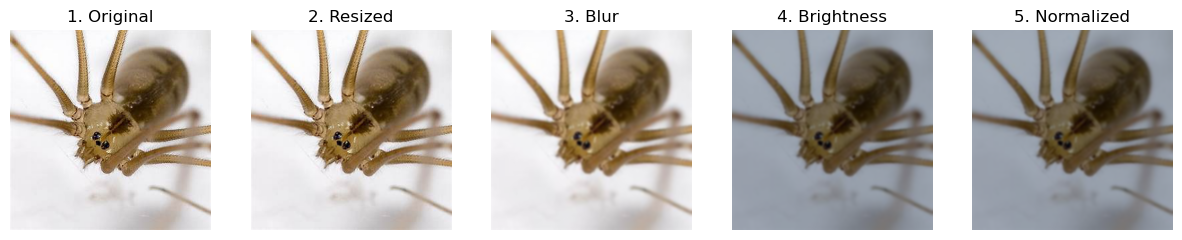


Showing pipeline for: D:\EDGE_INTELLIGENCE_LAB\archive (16)\raw-img\cavallo\OIP-LNLYTodvKr3U-UBulhgH4gHaEK.jpeg


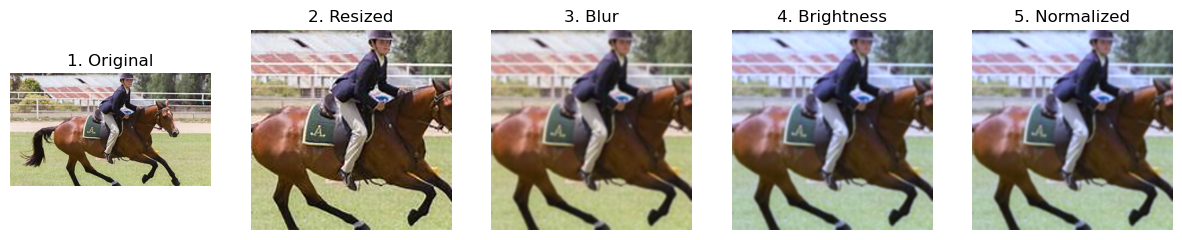


Showing pipeline for: D:\EDGE_INTELLIGENCE_LAB\archive (16)\raw-img\mucca\OIP-xbpTROO0gYplf5VD00esCgHaE1.jpeg


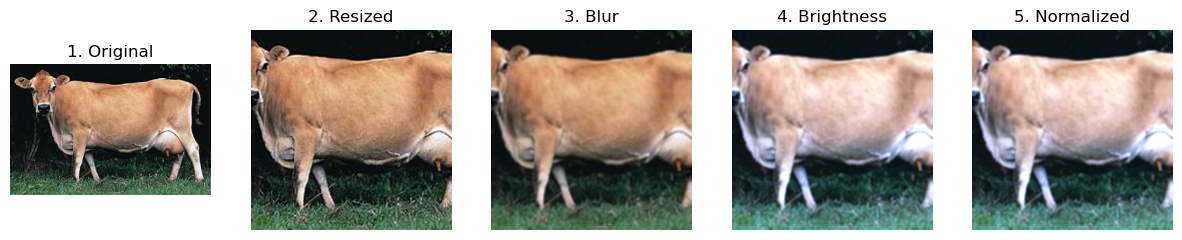

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0070207077..1.0000001].



Showing pipeline for: D:\EDGE_INTELLIGENCE_LAB\archive (16)\raw-img\gallina\594.jpeg


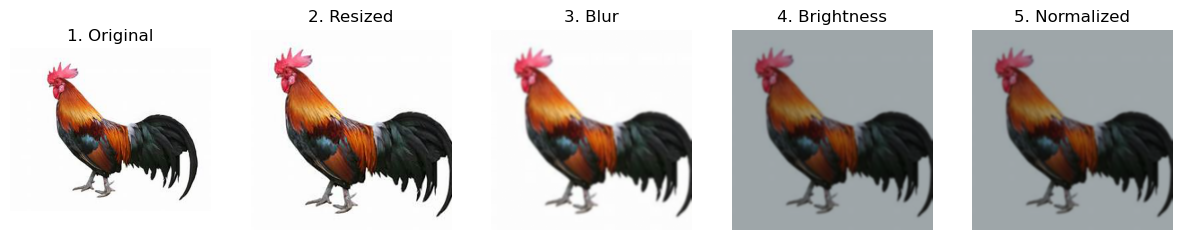

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.001708298..1.0000001].



Showing pipeline for: D:\EDGE_INTELLIGENCE_LAB\archive (16)\raw-img\elefante\OIP-76cOGCyVzwb5WN5Oikd5jwHaHc.jpeg


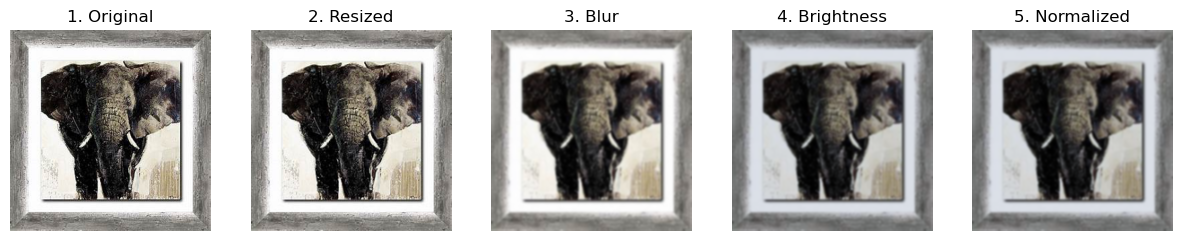

In [4]:
# ---------------------------------------------------------
#                IMPORT LIBRARIES
# ---------------------------------------------------------
import os
import torch
import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision.transforms.functional as F
from sklearn.model_selection import train_test_split


# ---------------------------------------------------------
#                PREPROCESSING FUNCTIONS
# ---------------------------------------------------------
def resize_keep_aspect(img, size=224):
    w, h = img.size
    if h < w:
        new_h = size
        new_w = int(w * size / h)
    else:
        new_w = size
        new_h = int(h * size / w)
    img = img.resize((new_w, new_h))
    left = (new_w - size) // 2
    top = (new_h - size) // 2
    return img.crop((left, top, left + size, top + size))


def gaussian_blur(img_tensor, kernel_size=5, sigma=1.1):
    return transforms.GaussianBlur(kernel_size=kernel_size, sigma=sigma)(img_tensor)


def auto_brightness_contrast(img_tensor, target_mean=0.5):
    mean = img_tensor.mean(dim=[1,2], keepdim=True)
    factor = target_mean / (mean + 1e-6)
    return torch.clamp(img_tensor * factor, 0, 1)


def normalize(img_tensor):
    return F.normalize(img_tensor, mean=[0.5]*3, std=[0.5]*3)


def preprocess_image(img):
    img = resize_keep_aspect(img, 224)
    t = F.to_tensor(img)
    t = gaussian_blur(t)
    t = auto_brightness_contrast(t)
    t = normalize(t)
    return t


# ---------------------------------------------------------
#       STEP-BY-STEP VISUALIZATION FUNCTION
# ---------------------------------------------------------
def show_step_by_step(img):
    fig, axes = plt.subplots(1, 5, figsize=(15, 4))

    axes[0].imshow(img)
    axes[0].set_title("1. Original")
    axes[0].axis("off")

    resized = resize_keep_aspect(img)
    axes[1].imshow(resized)
    axes[1].set_title("2. Resized")
    axes[1].axis("off")

    t = F.to_tensor(resized)
    blur = gaussian_blur(t)
    axes[2].imshow(blur.permute(1, 2, 0))
    axes[2].set_title("3. Blur")
    axes[2].axis("off")

    bright = auto_brightness_contrast(blur)
    axes[3].imshow(bright.permute(1, 2, 0))
    axes[3].set_title("4. Brightness")
    axes[3].axis("off")

    final = normalize(bright)
    img_np = final.permute(1, 2, 0).numpy()
    img_np = (img_np * 0.5) + 0.5
    img_np = np.clip(img_np, 0, 1)
    axes[4].imshow(img_np)
    axes[4].set_title("5. Normalized")
    axes[4].axis("off")

    plt.show()
    return final


# ---------------------------------------------------------
#                  DATASET LOADING
# ---------------------------------------------------------
DATASET_PATH = r"D:\EDGE_INTELLIGENCE_LAB\archive (16)\raw-img"

class_names = sorted([
    c for c in os.listdir(DATASET_PATH)
    if os.path.isdir(os.path.join(DATASET_PATH, c))
])

label_map = {c: i for i, c in enumerate(class_names)}

filepaths, labels = [], []

for c in class_names:
    folder = os.path.join(DATASET_PATH, c)
    for f in os.listdir(folder):
        if f.lower().endswith((".jpg", ".jpeg", ".png")):
            filepaths.append(os.path.join(folder, f))
            labels.append(label_map[c])

train_f, test_f, train_l, test_l = train_test_split(
    filepaths, labels, test_size=0.2, stratify=labels, random_state=42
)

print("Train size:", len(train_f))
print("Test size:", len(test_f))


# ---------------------------------------------------------
#       PICK 5 RANDOM IMAGES + SHOW STEP-BY-STEP
# ---------------------------------------------------------
random_indices = random.sample(range(len(train_f)), 5)
random_files = [train_f[i] for i in random_indices]
random_labels = [train_l[i] for i in random_indices]

print("\nRandom images selected:")
for fp in random_files:
    print(" ->", fp)

for fp in random_files:
    img = Image.open(fp).convert("RGB")
    print("\nShowing pipeline for:", fp)
    show_step_by_step(img)
